<a href="https://colab.research.google.com/github/naksh-atra/Cats_Gen/blob/main/Cats2_700.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [1/100] Batch 0/6 Loss D: 1.3576, Loss G: 2.6858 D(x): 0.4532, D(G(z)): 0.0711
Epoch [2/100] Batch 0/6 Loss D: 0.5391, Loss G: 6.1504 D(x): 0.8174, D(G(z)): 0.0023
Epoch [3/100] Batch 0/6 Loss D: 0.6341, Loss G: 11.0341 D(x): 0.9172, D(G(z)): 0.0000
Epoch [4/100] Batch 0/6 Loss D: 0.0840, Loss G: 6.8194 D(x): 0.9274, D(G(z)): 0.0012
Epoch [5/100] Batch 0/6 Loss D: 0.1231, Loss G: 8.6662 D(x): 0.9612, D(G(z)): 0.0002
Epoch [6/100] Batch 0/6 Loss D: 0.2705, Loss G: 15.9725 D(x): 0.7912, D(G(z)): 0.0000
Epoch [7/100] Batch 0/6 Loss D: 0.0388, Loss G: 12.5684 D(x): 0.9631, D(G(z)): 0.0000
Epoch [8/100] Batch 0/6 Loss D: 0.0929, Loss G: 14.4050 D(x): 0.9192, D(G(z)): 0.0000
Epoch [9/100] Batch 0/6 Loss D: 0.0367, Loss G: 8.7879 D(x): 0.9700, D(G(z)): 0.0002
Epoch [10/100] Batch 0/6 Loss D: 0.0521, Loss G: 5.8616 D(x): 0.9547, D(G(z)): 0.0035
Epoch [11/100] Batch 0/6 Loss D: 0.0786, Loss G: 7.3161 D(x): 0.9304, D(G(z)): 0.0015
Epoch [12/100] Batch 0/6 Loss D: 0.6884, Loss G: 9.4119 D(x

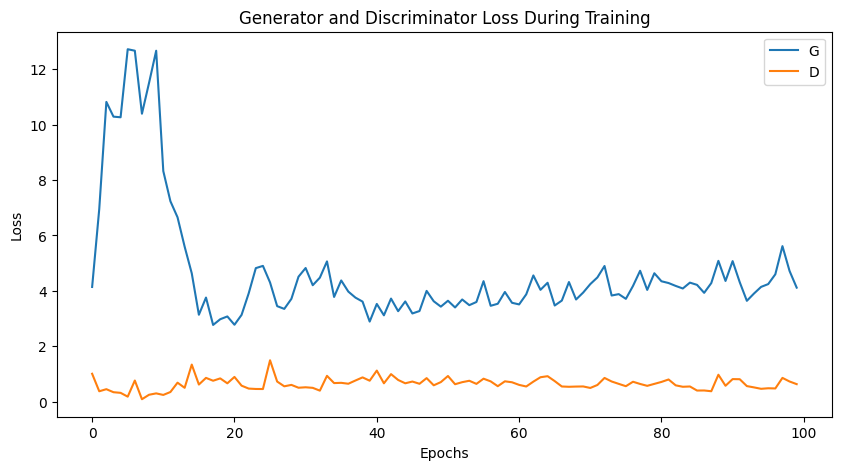

In [1]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np

# --------------------------
# Hyperparameters & Settings
# --------------------------
data_dir = '/content/drive/MyDrive/cats700'  # <-- Replace with your dataset path
image_size = 64
batch_size = 128
num_epochs = 100
learning_rate = 0.0002
beta1 = 0.5
nz = 100  # Size of z latent vector (i.e., size of generator input)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output_dir = 'output_images'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# --------------------------
# Custom Dataset for Loading Images without Classes
# --------------------------
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1]
])

dataset = ImageDataset(image_dir=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# --------------------------
# Model Definitions
# --------------------------
# Generator
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)

# Initialize models
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

# --------------------------
# Training Loop with Loss Tracking
# --------------------------
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
G_losses = []
D_losses = []

for epoch in range(num_epochs):
    G_loss_epoch = 0.0
    D_loss_epoch = 0.0

    for i, real_images in enumerate(dataloader, 0):
        # Update Discriminator
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Create real labels with dtype float
        label = torch.full((batch_size,), 1, device=device).float()
        output = netD(real_images)
        lossD_real = criterion(output, label)
        lossD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = netG(noise)

        # Create fake labels with dtype float
        label.fill_(0)
        output = netD(fake_images.detach())
        lossD_fake = criterion(output, label)
        lossD_fake.backward()
        optimizerD.step()

        # Update Generator
        netG.zero_grad()

        # Fake labels are real for generator cost
        label.fill_(1)
        output = netD(fake_images)
        lossG = criterion(output, label)
        lossG.backward()
        optimizerG.step()

        # Accumulate losses
        G_loss_epoch += lossG.item()
        D_loss_epoch += (lossD_real.item() + lossD_fake.item())

        # Print stats
        if i % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}] Batch {i}/{len(dataloader)} '
                  f'Loss D: {lossD_real.item()+lossD_fake.item():.4f}, Loss G: {lossG.item():.4f} '
                  f'D(x): {D_x:.4f}, D(G(z)): {output.mean().item():.4f}')

    # Record losses for plotting
    G_losses.append(G_loss_epoch / len(dataloader))
    D_losses.append(D_loss_epoch / len(dataloader))

    # Save fake images
    with torch.no_grad():
        fake_images = netG(fixed_noise).detach().cpu()
        vutils.save_image(fake_images, os.path.join(output_dir, f'fake_samples_epoch_{epoch+1}.png'), normalize=True)

# --------------------------
# Plot the Training and Validation Loss
# --------------------------
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Save the final models
torch.save(netG.state_dict(), 'generator.pth')
torch.save(netD.state_dict(), 'discriminator.pth')
